<a href="https://colab.research.google.com/github/GaioAugusto/APS360-Labs/blob/main/Lab3_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1h6mnc9C_PXjQlwb3c8hirQUoKTGHszKB/view?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import os
import random
import shutil
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import numpy as np



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive_data_path = '/content/drive/My Drive/APS360/LAB-3/Lab3_Gestures_Summer'
local_data_path = '/content/Lab3_Gestures_Summer'

if os.path.exists(local_data_path):
    shutil.rmtree(local_data_path)
shutil.copytree(drive_data_path, local_data_path)
print("Data copied to local storage:", local_data_path)

Mounted at /content/drive
Data copied to local storage: /content/Lab3_Gestures_Summer


In [ ]:
def create_folder(folder_path: str):
  # Check if folder exists and create it if not
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)


In [ ]:
import random

splitDataPath = '/content/Lab3_Data'  # local
os.makedirs(splitDataPath, exist_ok=True)

training_folder = os.path.join(splitDataPath, 'Training')
validation_folder = os.path.join(splitDataPath, 'Validation')
testing_folder = os.path.join(splitDataPath, 'Testing')

for folder in [training_folder, validation_folder, testing_folder]:
    os.makedirs(folder, exist_ok=True)

train_ratio, validation_ratio, testing_ratio = 0.7, 0.2, 0.1

for gesture in os.listdir(local_data_path):
    gesture_path = os.path.join(local_data_path, gesture)
    if not os.path.isdir(gesture_path):
        continue

    # Create gesture folders
    for split_folder in [training_folder, validation_folder, testing_folder]:
        os.makedirs(os.path.join(split_folder, gesture), exist_ok=True)

    images = os.listdir(gesture_path)
    random.shuffle(images)

    total_images = len(images)
    training_part = int(total_images * train_ratio)
    validation_part = int(total_images * validation_ratio)
    testing_part = total_images - training_part - validation_part  # rest

    training_images = images[:training_part]
    validation_images = images[training_part: training_part + validation_part]
    test_images = images[training_part + validation_part:]

    for image in training_images:
        shutil.copy(os.path.join(gesture_path, image),
                    os.path.join(training_folder, gesture, image))
    for image in validation_images:
        shutil.copy(os.path.join(gesture_path, image),
                    os.path.join(validation_folder, gesture, image))
    for image in test_images:
        shutil.copy(os.path.join(gesture_path, image),
                    os.path.join(testing_folder, gesture, image))

print("Data split complete at:", splitDataPath)

Data split complete at: /content/Lab3_Data


In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root=os.path.join(splitDataPath, 'Training'),
                                     transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(splitDataPath, 'Validation'),
                                   transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(splitDataPath, 'Testing'),
                                    transform=transform)

print(len(train_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True,
                                           num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False,
                                         num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False,
                                          num_workers=2, pin_memory=True)

1548


In [ ]:
from PIL import Image

base_folders = [
    '/content/Lab3_Data/Training',
    '/content/Lab3_Data/Validation',
    '/content/Lab3_Data/Testing'
]

for base_folder in base_folders:
    for gesture in os.listdir(base_folder):
        gesture_path = os.path.join(base_folder, gesture)
        if not os.path.isdir(gesture_path):
            continue

        for fname in os.listdir(gesture_path):
            full_path = os.path.join(gesture_path, fname)
            try:
                with Image.open(full_path) as img:
                    img.verify()  # verify load
            except Exception as e:
                print(f"Removing corrupted file: {full_path}")
                os.remove(full_path)

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = None  # initialized in forward
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 + Pool 224 → 74
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 + Pool 74 → 36
        x = self.pool3(F.relu(self.conv3(x)))  # Conv3 + Pool 36 → 12

        if self.fc1 is None:
            self.flattened_size = x.view(x.shape[0], -1).shape[1]
            self.fc1 = nn.Linear(self.flattened_size, 512).to(x.device)  # Update fc1
            self.to(x.device)

        x = x.view(x.shape[0], -1)  # Flatten tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

I decided to use 3 conv layers with pooling after each one (the first two are more aggressive with a kernel size and stride of 3 and the last pooling has kernel size and stride of 2). Then I decided to use 3 fully connected layers to smoothen the transition to 9 classes. To try to avoid overfitting I included a dropout of 0.4

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
# Code from lab 2
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}.pt".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(net, loader, criterion, device):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)  # Get class highest probability
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(loader)
    error_rate = float(total_err) / total_samples

    return error_rate, avg_loss

def train_net(net, train_loader, val_loader, name="CNN", batch_size=32, learning_rate=0.001, num_epochs=30, checkpoint_freq=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device} GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

    net.to(device)  # Move model to GPU

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()

    for epoch in range(num_epochs):
        net.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_samples += labels.size(0)

        train_err[epoch] = float(total_train_err) / total_samples
        train_loss[epoch] = total_train_loss / (i + 1)

        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion, device)

        print(("Epoch {}: Train err: {:.4f}, Train loss: {:.4f} | "+
               "Validation err: {:.4f}, Validation loss: {:.4f}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))

        if (epoch + 1) % checkpoint_freq == 0:
            model_path = get_model_name(name, batch_size, learning_rate, epoch + 1)
            torch.save(net.state_dict(), model_path)
            print(f"Model saved at: {model_path}")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

def plot_training_curve(path):
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

I decided to use Cross-Entropy as the loss function because it works better for multiple classes (which is the case in this lab -> 9 classes). I also chose to use Adam optimizer because it works better with CNNs

In [ ]:
print("Is CUDA available? ", torch.cuda.is_available())
print("Device count: ", torch.cuda.device_count())
print("Current device: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Is CUDA available?  True
Device count:  1
Current device:  0
GPU Name:  NVIDIA A100-SXM4-40GB


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
smallTrainDataset = Subset(train_dataset, range(100))

smallTrainLoader = DataLoader(smallTrainDataset, batch_size=len(smallTrainDataset), shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

train_net(model, smallTrainLoader, smallTrainLoader, num_epochs=20, batch_size=len(smallTrainDataset), learning_rate=0.001)

Using device: cpu GPU: None
Epoch 1: Train err: 1.0000, Train loss: 2.1837 | Validation err: 0.0000, Validation loss: 2.1171
Epoch 2: Train err: 0.0000, Train loss: 2.1186 | Validation err: 0.0000, Validation loss: 2.0145
Epoch 3: Train err: 0.0000, Train loss: 2.0150 | Validation err: 0.0000, Validation loss: 1.8495
Epoch 4: Train err: 0.0000, Train loss: 1.8524 | Validation err: 0.0000, Validation loss: 1.5837
Epoch 5: Train err: 0.0000, Train loss: 1.5820 | Validation err: 0.0000, Validation loss: 1.1953
Model saved at: model_CNN_bs100_lr0.001_epoch5.pt
Epoch 6: Train err: 0.0000, Train loss: 1.1940 | Validation err: 0.0000, Validation loss: 0.7076
Epoch 7: Train err: 0.0000, Train loss: 0.7071 | Validation err: 0.0000, Validation loss: 0.2654
Epoch 8: Train err: 0.0000, Train loss: 0.2667 | Validation err: 0.0000, Validation loss: 0.0503
Epoch 9: Train err: 0.0000, Train loss: 0.0563 | Validation err: 0.0000, Validation loss: 0.0052
Epoch 10: Train err: 0.0000, Train loss: 0.0059 |

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

Kernel size and stride of pooling, learning rate, and number of epochs

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
model1 = CNN()

train_net(model1, train_loader, val_loader, name="CNN_model1", num_epochs=20, learning_rate=0.001)

Using device: cuda GPU: Tesla T4
Epoch 1: Train err: 0.8908, Train loss: 2.1989 | Validation err: 0.8364, Validation loss: 2.1946
Epoch 2: Train err: 0.7862, Train loss: 2.0451 | Validation err: 0.6045, Validation loss: 1.6590
Epoch 3: Train err: 0.5375, Train loss: 1.5294 | Validation err: 0.4909, Validation loss: 1.3904
Epoch 4: Train err: 0.4587, Train loss: 1.3068 | Validation err: 0.4682, Validation loss: 1.2418
Epoch 5: Train err: 0.4115, Train loss: 1.2014 | Validation err: 0.3886, Validation loss: 1.1339
Model saved at: model_CNN_model1_bs32_lr0.001_epoch5.pt
Epoch 6: Train err: 0.3734, Train loss: 1.1038 | Validation err: 0.3477, Validation loss: 1.0796
Epoch 7: Train err: 0.3630, Train loss: 1.0574 | Validation err: 0.3545, Validation loss: 0.9687
Epoch 8: Train err: 0.3572, Train loss: 0.9973 | Validation err: 0.3250, Validation loss: 0.9576
Epoch 9: Train err: 0.3398, Train loss: 0.9623 | Validation err: 0.3273, Validation loss: 0.9148
Epoch 10: Train err: 0.3327, Train los

In [ ]:
model2 = CNN()
train_net(model2, train_loader, val_loader, name="CNN_model2", num_epochs=40, learning_rate=0.0005)

Using device: cuda GPU: Tesla T4
Epoch 1: Train err: 0.8727, Train loss: 2.1939 | Validation err: 0.7273, Validation loss: 2.1636
Epoch 2: Train err: 0.6764, Train loss: 1.8435 | Validation err: 0.5364, Validation loss: 1.4849
Epoch 3: Train err: 0.4851, Train loss: 1.3873 | Validation err: 0.3705, Validation loss: 1.1719
Epoch 4: Train err: 0.4057, Train loss: 1.1832 | Validation err: 0.3727, Validation loss: 1.0702
Epoch 5: Train err: 0.3837, Train loss: 1.0957 | Validation err: 0.3273, Validation loss: 0.9728
Model saved at: model_CNN_model2_bs32_lr0.0005_epoch5.pt
Epoch 6: Train err: 0.3521, Train loss: 1.0450 | Validation err: 0.3432, Validation loss: 0.9600
Epoch 7: Train err: 0.3185, Train loss: 0.9462 | Validation err: 0.2932, Validation loss: 0.8516
Epoch 8: Train err: 0.3043, Train loss: 0.9202 | Validation err: 0.2977, Validation loss: 0.8348
Epoch 9: Train err: 0.3030, Train loss: 0.8883 | Validation err: 0.2886, Validation loss: 0.8279
Epoch 10: Train err: 0.2771, Train lo

In [ ]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = None
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        if self.fc1 is None:
            flattened_size = x.view(x.shape[0], -1).shape[1]
            self.fc1 = nn.Linear(flattened_size, 512).to(x.device)
            self.to(x.device)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
model3 = CNN_2()

train_net(model3, train_loader, val_loader, name="CNN_2_model3" , num_epochs=40, learning_rate=0.0005)

Using device: cuda GPU: NVIDIA A100-SXM4-40GB
Epoch 1: Train err: 0.8928, Train loss: 2.1988 | Validation err: 0.8886, Validation loss: 2.1954
Epoch 2: Train err: 0.8217, Train loss: 2.1611 | Validation err: 0.7114, Validation loss: 1.9819
Epoch 3: Train err: 0.6318, Train loss: 1.6983 | Validation err: 0.4977, Validation loss: 1.4495
Epoch 4: Train err: 0.4767, Train loss: 1.3628 | Validation err: 0.4136, Validation loss: 1.2371
Epoch 5: Train err: 0.4154, Train loss: 1.1699 | Validation err: 0.3864, Validation loss: 1.1453
Model saved at: model_CNN_2_model3_bs32_lr0.0005_epoch5.pt
Epoch 6: Train err: 0.3908, Train loss: 1.1209 | Validation err: 0.3273, Validation loss: 1.0476
Epoch 7: Train err: 0.3656, Train loss: 1.0478 | Validation err: 0.3455, Validation loss: 1.0437
Epoch 8: Train err: 0.3379, Train loss: 0.9904 | Validation err: 0.3227, Validation loss: 0.9907
Epoch 9: Train err: 0.3495, Train loss: 0.9611 | Validation err: 0.2977, Validation loss: 0.9371
Epoch 10: Train err: 0

In [ ]:
model4 = CNN_2()

train_net(model4, train_loader, val_loader, name="CNN_2_model4" ,num_epochs=50, learning_rate=0.001)

Using device: cuda GPU: Tesla T4
Epoch 1: Train err: 0.8721, Train loss: 2.1966 | Validation err: 0.7705, Validation loss: 2.1799
Epoch 2: Train err: 0.6848, Train loss: 1.9168 | Validation err: 0.5568, Validation loss: 1.5704
Epoch 3: Train err: 0.5194, Train loss: 1.4498 | Validation err: 0.4545, Validation loss: 1.2843
Epoch 4: Train err: 0.4444, Train loss: 1.2518 | Validation err: 0.3682, Validation loss: 1.1302
Epoch 5: Train err: 0.3934, Train loss: 1.1407 | Validation err: 0.3614, Validation loss: 1.0271
Model saved at: model_CNN_2_model4_bs32_lr0.001_epoch5.pt
Epoch 6: Train err: 0.3773, Train loss: 1.0534 | Validation err: 0.3136, Validation loss: 0.9404
Epoch 7: Train err: 0.3430, Train loss: 0.9812 | Validation err: 0.3455, Validation loss: 0.9099
Epoch 8: Train err: 0.3288, Train loss: 0.9285 | Validation err: 0.2864, Validation loss: 0.8548
Epoch 9: Train err: 0.3075, Train loss: 0.8559 | Validation err: 0.2841, Validation loss: 0.8070
Epoch 10: Train err: 0.2752, Train l

Model 1


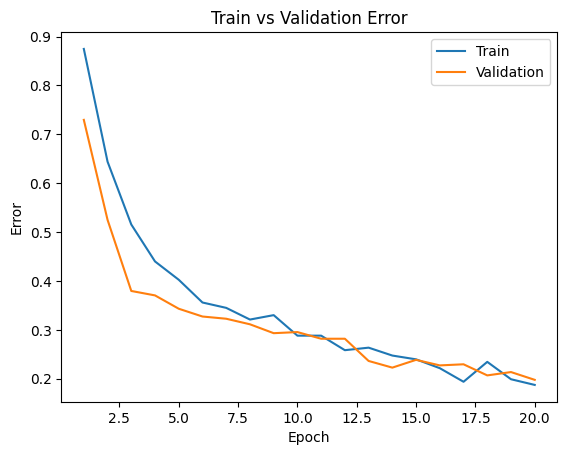

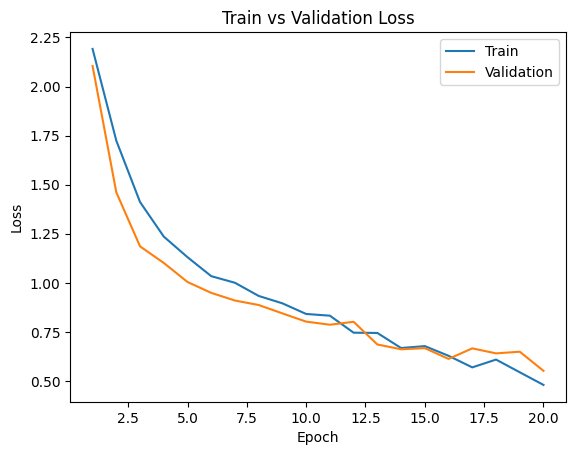

In [ ]:
model_path1 = get_model_name("gesture_cnn", 32, 0.001, 20)
print("Model 1")
plot_training_curve(model_path1)

Model 2


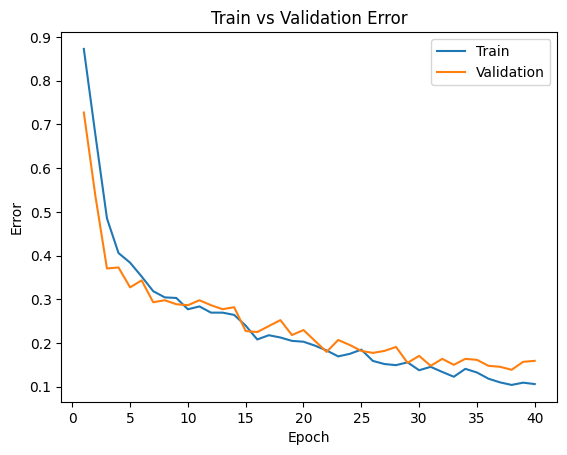

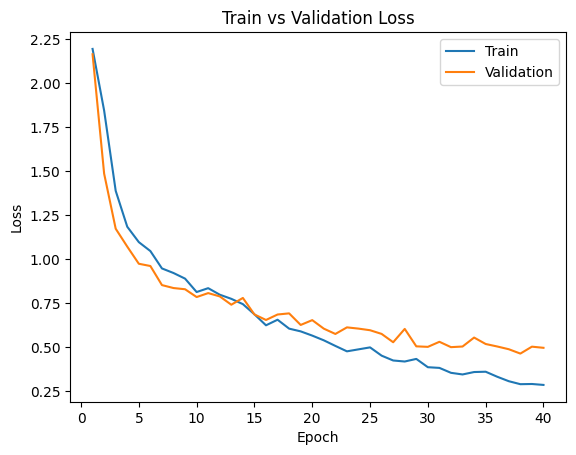

In [ ]:
model_path2 = get_model_name("CNN_model2", batch_size=32, learning_rate=0.0005, epoch=40)
print("Model 2")
plot_training_curve(model_path2)

Model 3


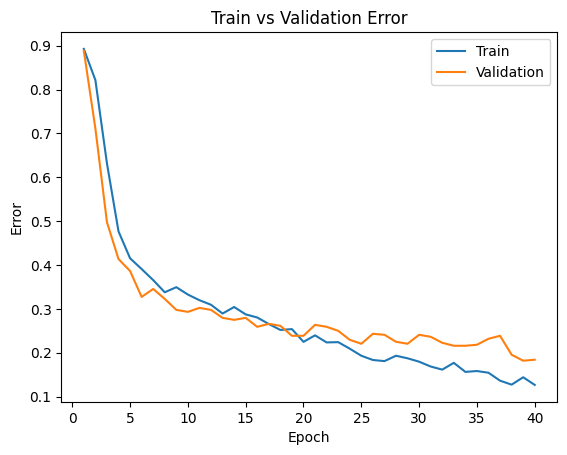

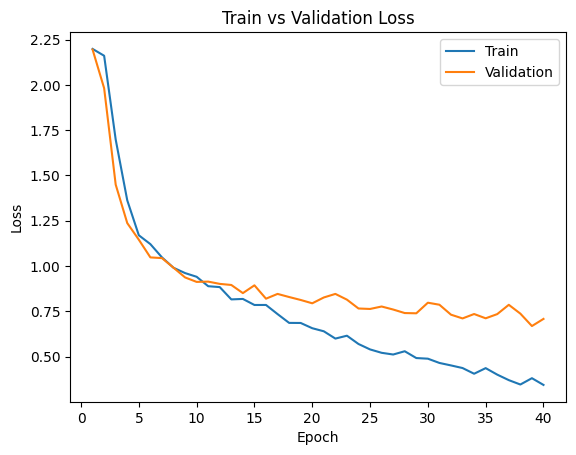

In [ ]:
model_path3 = get_model_name("CNN_2_model3", batch_size=32, learning_rate=0.0005, epoch=40)
print("Model 3")
plot_training_curve(model_path3)

Model 4


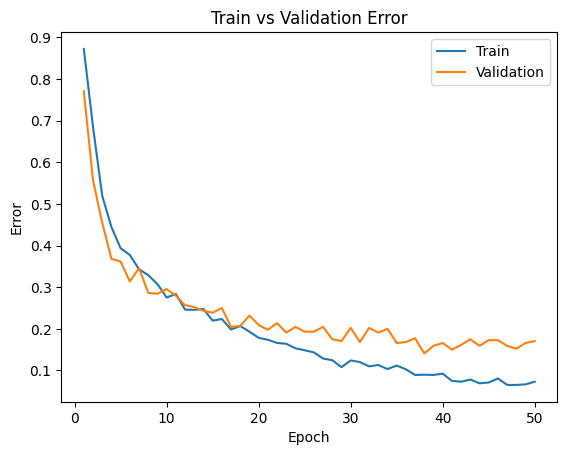

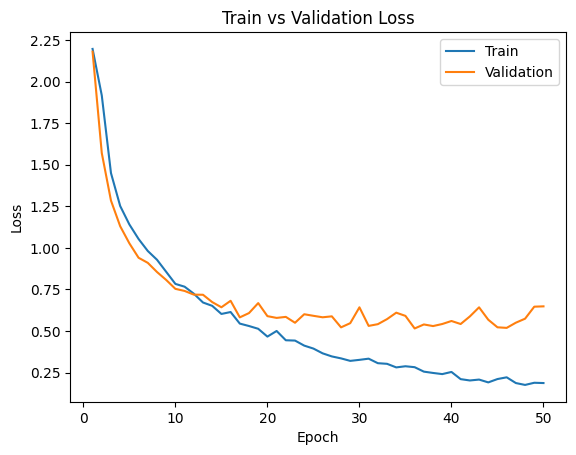

In [ ]:
model_path4 = get_model_name("CNN_2_model4", batch_size=32, learning_rate=0.001, epoch=50)
print("Model 4")
plot_training_curve(model_path4)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

The best model was model3, that used pooling dimensions for kernel size and stride of 2. The model also ran for 40 epochs and 0.0005 learning rate. This model achieved almost the same validation error, and the lowest validation loss by far.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

criterion = nn.CrossEntropyLoss().to(device)

testError, testLoss = evaluate(model3, test_loader, criterion, device)

print(f"Test Error: {testError:.4f}")
print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {100 * (1 - testError):.2f}%")

Test Error: 0.1775
Test Loss: 0.5255
Test Accuracy: 82.25%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 191MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
filePath = '/content/drive/My Drive/Lab3_Gestures_Summer'
outputPath = '/content/drive/My Drive/Lab3_Gestures_Summer/AlexNetData'

datasetFolders = {
    "Training": os.path.join(outputPath, "Training"),
    "Validation": os.path.join(outputPath, "Validation"),
    "Test": os.path.join(outputPath, "Test")
}

for folder in datasetFolders.values():
    create_folder(folder)

gestures = [gesture for gesture in os.listdir(filePath) if os.path.isdir(os.path.join(filePath, gesture))]

for dataset_path in datasetFolders.values():
    for gesture in gestures:
        os.makedirs(os.path.join(dataset_path, gesture), exist_ok=True)

alexnet.eval()

trainLoaderNew = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validationLoaderNew = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
testLoaderNew = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
def saveFeatures(dataLoader, outputDirectory):
    label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I'}

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataLoader):
            extracted_features = alexnet.features(images).detach().cpu().numpy()  # Convert to NumPy

            for img_idx, (feature, label) in enumerate(zip(extracted_features, labels)):
                gesture_class = label_map[label.item()]
                gesture_folder = os.path.join(outputDirectory, gesture_class)
                os.makedirs(gesture_folder, exist_ok=True)

                # Convert back to tensor
                tensor_path = os.path.join(gesture_folder, f'{batch_idx}_{img_idx}.pt')
                torch.save(torch.from_numpy(feature), tensor_path)

In [ ]:
for dataset in ["Training", "Validation", "Test"]:
    dataset_path = training_folder if dataset == "Training" else (validation_folder if dataset == "Validation" else testing_folder)
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".tensor") or file.endswith(".pt"):  # Delete all old .tensor files
                os.remove(os.path.join(root, file))

In [ ]:
for dataset_loader, dataset_path in zip([trainLoaderNew, validationLoaderNew, testLoaderNew], datasetFolders.values()):
    saveFeatures(dataset_loader, dataset_path)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

NameError: name 'model' is not defined

In [ ]:
import torch.nn.functional as F

class new_classifier(nn.Module):
    def __init__(self):
        super(new_classifier, self).__init__()

        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(256, 9)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

I decided to use fully-connected because convolutional features were already extracted with alexnet. I chose 4 layers to gradually descend the number of neurons and dropout after each layer to reduce overfitting and improve generalization.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

NameError: name 'tensor' is not defined

In [ ]:
print("Dataset Path for Training:", datasetFolders["Training"])

datasetFolders["Training"] = "/content/drive/My Drive/Lab3_Gestures_Summer/AlexNetData/Training"
datasetFolders["Validation"] = "/content/drive/My Drive/Lab3_Gestures_Summer/AlexNetData/Validation"
datasetFolders["Test"] = "/content/drive/My Drive/Lab3_Gestures_Summer/AlexNetData/Test"

Dataset Path for Training: /content/drive/My Drive/Lab3_Gestures_Summer/AlexNetData/Training


In [ ]:
for dataset in datasetFolders.values():
    alexnet_subfolder = os.path.join(dataset, "AlexNetData")
    if os.path.exists(alexnet_subfolder):
        shutil.rmtree(alexnet_subfolder)

In [ ]:
for dataset in datasetFolders.values():
    alexnet_data_path = os.path.join(dataset, "AlexNetData")
    if os.path.exists(alexnet_data_path):
        shutil.rmtree(alexnet_data_path)

In [ ]:
trainFeatures = torchvision.datasets.DatasetFolder(
    root=datasetFolders["Training"],
    loader=torch.load,
    extensions=('.tensor')
)

validationFeatures = torchvision.datasets.DatasetFolder(
    root=datasetFolders["Validation"],
    loader=torch.load,
    extensions=('.tensor')
)

testFeatures = torchvision.datasets.DatasetFolder(
    root=datasetFolders["Test"],
    loader=torch.load,
    extensions=('.tensor')
)
trainFeatureLoader = torch.utils.data.DataLoader(trainFeatures, batch_size=64, shuffle=True)
validationFeatureLoader = torch.utils.data.DataLoader(validationFeatures, batch_size=64, shuffle=True)
testFeatureLoader = torch.utils.data.DataLoader(testFeatures, batch_size=64, shuffle=True)

In [ ]:
model_alex = new_classifier()
train_net(model_alex, trainFeatureLoader, validationFeatureLoader, name="model_alex")

Using device: cpu GPU: None


/usr/local/lib/python3.11/dist-packages/torchvision/datasets/folder.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample = self.loader(path)


Epoch 1: Train err: 0.6466, Train loss: 1.6817 | Validation err: 0.2727, Validation loss: 0.8670
Epoch 2: Train err: 0.2894, Train loss: 0.7454 | Validation err: 0.1841, Validation loss: 0.5062
Epoch 3: Train err: 0.1848, Train loss: 0.4801 | Validation err: 0.1341, Validation loss: 0.3962
Epoch 4: Train err: 0.1079, Train loss: 0.3218 | Validation err: 0.0977, Validation loss: 0.3398
Epoch 5: Train err: 0.0782, Train loss: 0.2399 | Validation err: 0.1136, Validation loss: 0.3500
Model saved at: model_model_alex_bs32_lr0.001_epoch5.pt
Epoch 6: Train err: 0.0698, Train loss: 0.2035 | Validation err: 0.1091, Validation loss: 0.2940
Epoch 7: Train err: 0.0607, Train loss: 0.1727 | Validation err: 0.0750, Validation loss: 0.2570
Epoch 8: Train err: 0.0452, Train loss: 0.1448 | Validation err: 0.0886, Validation loss: 0.3028
Epoch 9: Train err: 0.0420, Train loss: 0.1348 | Validation err: 0.0909, Validation loss: 0.3238
Epoch 10: Train err: 0.0349, Train loss: 0.1215 | Validation err: 0.079

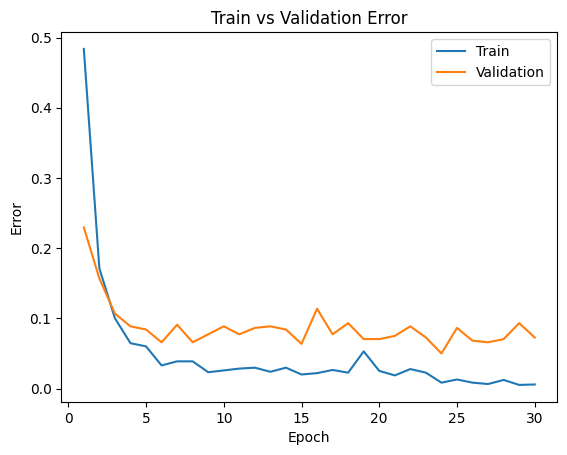

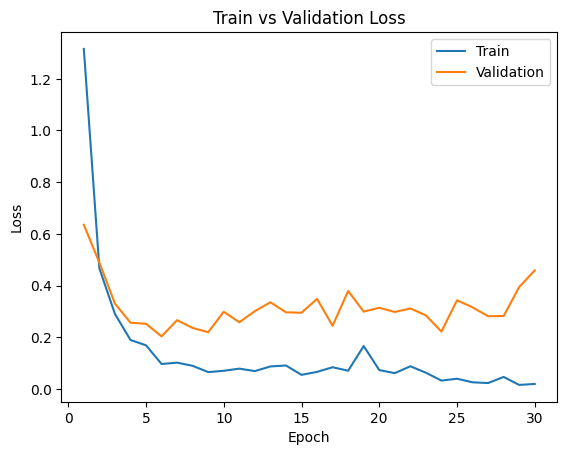

In [ ]:
model_path = get_model_name("CNN", batch_size=32, learning_rate=0.001, epoch=30)
plot_training_curve(model_path)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_alex.to(device)

criterion = nn.CrossEntropyLoss().to(device)

testError, testLoss = evaluate(model_alex, testFeatureLoader, criterion, device)

print(f"Test Error: {testError:.4f}")
print(f"Test Loss: {testLoss:.4f}")
print(f"Test Accuracy: {100 * (1 - testError):.2f}%")

Test Error: 0.0563
Test Loss: 0.1837
Test Accuracy: 94.37%


My test accuracy from the 3(d) model was 82.25%, which is much lower than the 94.37% accuracy achieved using transfer learning.